In [6]:
import matplotlib.pyplot as plt
from pathlib import Path


# Biocellion Output Plotting
This notebook defines functions to read and plot the biocellion output data for the Biocellion ABM models by the CMMC that can be found in github.com/TheCMMC. For more information on the CMMC, visit www.thecmmc.org.  

To use these plotting functions the biocellion output summary should be in one directory with the following naming pattern:
`output_parameter{par_id}_trial{trial}.txt`

If the scripts and instructions in https://github.com/TheCMMC/biocellion-tools have been used to create the output, this notebook should be able to run with the resulting data.

## User settings

In [20]:
# Set this data folder to the place where you cloned the repository https://github.com/TheCMMC/biocellion-data
DATA_FOLDER = Path("/home/jaroknor/NLeSC/InSilicoMeat/Biocellion/Biocellion-3.1/biocellion-3.1/biocellion-user/biocellion-data")

## Plotting functions

In [21]:
ABM_ONLY_FOLDER = DATA_FOLDER / "PLOSone_ABM-only-microcarrier"
ABM_CFD_FOLDER = DATA_FOLDER / "PLOSone_ABM-CFD-microcarrier"

In [37]:
def read_summary_file(filename):
    live, attached, dead, removed = ([],[],[],[])

    with open(filename, 'r' ) as f :
        for line in f:
            if 'Live Cells' in line :
              live.append( int( line.strip().split(':')[-1] ) )
            if 'Live Attached Cells' in line :
              attached.append( int( line.strip().split(':')[-1] ) )
            elif 'Death Cells' in line:
              dead.append( int( line.strip().split(':')[-1] ))
            elif 'Removed Cells' in line :
              removed.append( int( line.strip().split(':')[-1] ))
    
    # if the lengths of these list are different print error
    assert len(live)==len(attached)==len(dead)==len(removed), "Cell count lists are of different lenghts"

    return {"live":live, "attached":attached, "dead":dead, "removed":removed}

def plot_single_summary(par_id, trial, data_folder):
    filename = data_folder / f"output_parameter{par_id}_trial{trial}.txt"
    cell_counts = read_summary_file(filename)

    Npoints = len( cell_counts["live"] )
    tsteps = range( Npoints)

    fig, ax = plt.subplots()
    ax.plot(tsteps, cell_counts["live"], '-b', label='Live')
    ax.plot(tsteps, cell_counts["attached"], '-g', label='Attached')
    ax.plot(tsteps, cell_counts["dead"], '-r', label='Apoptotic')
    ax.plot(tsteps, cell_counts["removed"], '-k', label='Dead')
    leg = ax.legend();
    plt.ylabel('Cell count (one microcarrier)')
    plt.xlabel('Time steps')
    plt.savefig("ABMOnly_cell_counts.png", dpi=150)
    
def plot_multi_summary(par_ids, trials, states, data_folder):
    for par_id in par_ids:
        for trial in trials:
            filename =  f"log_parameter{par_id}_trial{trial}.txt"

        

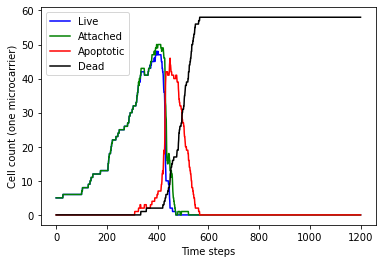

In [38]:
plot_single_summary(31, 8, ABM_CFD_FOLDER)
# plot_multi_summary()